In [5]:
from collections import OrderedDict
import sys
from pathlib import Path
import json
import time
import math
import csv
from datetime import datetime
from random import randint

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.manifold import TSNE
import sklearn.cluster

import cv2

import kornia

import torch
import torch.nn as nn

import torchvision as tv
from torchvision.models import resnet50, ResNet50_Weights, resnet34
from torchvision.transforms import functional as tfunc

sys.path.append('../mine_soar')
import MalmoPython
from utils import draw_image, draw_layers

MISSION_PORT = 9001
VIDEO_SHAPE = (128, 128)
VIDEO_DEPTH = 3
DEVICE = 'cuda:0'
# DEVICE = 'cpu'

MALMO_HOST = MalmoPython.AgentHost()
malmo_client_pool = MalmoPython.ClientPool()
for i in range(3): 
    malmo_client_info = MalmoPython.ClientInfo('127.0.0.1', MISSION_PORT+i)
    malmo_client_pool.add(malmo_client_info)

def start_mission(file="random_world.xml"):
    MALMO_HOST.sendCommand("quit")
    while MALMO_HOST.getWorldState().is_mission_running:
        time.sleep(0.1)
    
    mission_file = Path(file)
    random_world_mission_spec = MalmoPython.MissionSpec(mission_file.read_text(), True)
    random_world_record_spec = MalmoPython.MissionRecordSpec()
    MALMO_HOST.startMission(random_world_mission_spec, 
                                  malmo_client_pool,
                                  random_world_record_spec,
                                  0,
                                  "TEST ALPHA")
    while not MALMO_HOST.getWorldState().is_mission_running:
        time.sleep(0.1)
    MALMO_HOST.sendCommand("jump 1")
    time.sleep(0.1)
    MALMO_HOST.sendCommand("jump 0")

def get_mc_img(show=False, transform=None):
    state = MALMO_HOST.getWorldState()
    if not state.is_mission_running:
        raise Exception("No mission running")
    while state.number_of_video_frames_since_last_state < 1 or state.number_of_observations_since_last_state < 1:
        time.sleep(0.1)
        state = MALMO_HOST.getWorldState()
    image = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
    image = image.reshape(VIDEO_SHAPE+(4,))
    
    if VIDEO_DEPTH == 3:
        image = image[:,:,:3]
    image_tensor = tfunc.to_tensor(image).to(DEVICE).unsqueeze(0)
    if transform:
        image_tensor = transform(image_tensor)
        image_tensor -= image_tensor.min()
        image_tensor /= image_tensor.max()
    
    obs = json.loads(state.observations[0].text)
    x = obs['XPos']
    y = obs['YPos']
    z = obs['ZPos']
    pitch = obs['Pitch']
    yaw = obs['Yaw']
    world_time = obs['WorldTime']
    life_time = obs['TimeAlive']
    agent_data = np.array([x, y, z, pitch, yaw, world_time, life_time]).astype(np.float32)
    agent_data_tensor = torch.Tensor(agent_data).to(DEVICE)
    
    if show:
        plt.imshow(image)
        plt.show()
        plt.close()
    return image, image_tensor, agent_data_tensor

In [6]:
def test_model(model, loss_fn, opt_method, iters=1001, show_step=100, reset_step=100):
    model_optim = opt_method(model.parameters())
    model.train()
    
    session_id = f"{datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M-%S')}"
    save_root = Path(".runs/"+session_id+"/")
    save_root.mkdir()
    start_mission()
    
    losses = []
    images = []
    
    for i in range(iters):
        MALMO_HOST.sendCommand("turn 0.1")
        img, img_tens, agent_data = get_mc_img(False)

        model_out = model(img_tens)

        loss = loss_fn(img_tens, model_out)

        loss.backward()

        model_optim.step()

        print(f"{i}: loss 2d={loss.item()}")
        losses.append(loss.item())

        model_optim.zero_grad()

        if i % show_step == 0:
            image = torch.concat([img_tens, model_out], dim=3)
            draw_image(image, show=True)
            images.append(image.detach().cpu().squeeze())
        if reset_step is not None and i % reset_step == 0:
            MALMO_HOST.sendCommand("quit")
            time.sleep(0.5)
            start_mission()

    
    with open(save_root.joinpath("losses.csv"), "w") as csv_file:
        for loss in losses:
            csv_file.write(f"{loss},\n")
    for i, img in enumerate(images):
        draw_image(img, save_root.joinpath(f"images_{i*show_step}.png"))
    plt.figure()
    plt.plot(losses)
    plt.savefig(save_root.joinpath("losses.png"))
    with open(save_root.joinpath("model.txt"), "w") as model_file:
        model_file.write(str(model))
    
    MALMO_HOST.sendCommand("quit")

In [7]:
# test_tens = torch.randn((1,3, 128, 128)).to(DEVICE)
# test_conv = nn.Conv2d(3, 8, 127, 1, 63).to(DEVICE)
# print(test_conv(test_tens).shape)

In [8]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_dims, mid_dims, out_dims, padding="zeros", downscale=False, upscale=False):
        super().__init__()
        
        self.downscale = downscale
        self.upscale = upscale
        
        if downscale:
            self.downscale_layer = nn.Sequential(
                nn.Conv2d(in_dims, in_dims, 3, 2, 1, padding_mode=padding),
                nn.BatchNorm2d(in_dims),
                nn.LeakyReLU()
            )
            
        self.dim_compress = nn.Sequential(
            nn.Conv2d(in_dims, mid_dims, 1, 1, 0),
            nn.BatchNorm2d(mid_dims),
            nn.LeakyReLU()
        )
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(mid_dims, mid_dims, 5, 1, 2, padding_mode=padding),
            nn.BatchNorm2d(mid_dims),
            nn.LeakyReLU()
        )
        
        self.dim_extend = nn.Sequential(
            nn.Conv2d(mid_dims, out_dims, 1, 1, 0),
            nn.BatchNorm2d(out_dims),
            nn.LeakyReLU()
        )
        
        if upscale:
            self.upscale_layer = nn.Sequential(
                nn.ConvTranspose2d(out_dims, out_dims, 2, 2, 0),
                nn.BatchNorm2d(out_dims),
                nn.LeakyReLU()
            )
        
    def forward(self, x):
        if self.downscale:
            x = self.downscale_layer(x)
        x = self.dim_compress(x)
        x = self.bottleneck(x)
        x = self.dim_extend(x)
        if self.upscale:
            x = self.upscale_layer(x)
        return x
        

In [9]:
H_in = 64
stride = 2
padding =0
dilation = 1
kernel_size = 2
output_padding = 0
H_out = (H_in-1)*stride - 2*padding + dilation*(kernel_size-1) + output_padding + 1
print(H_out)

128


In [10]:
pad_mode = "reflect"

class AE_H1_Model(nn.Module):
    def __init__(self, init_channels=64):
        super().__init__()
        channels = [init_channels*(2**e) for e in range(5)]
        intake = BottleneckBlock(3, channels[0], channels[1], padding=pad_mode)
        
        compress1 = BottleneckBlock(channels[1], channels[0], channels[2], downscale=True, padding=pad_mode)
        compress2 = BottleneckBlock(channels[2], channels[1], channels[3], downscale=False, padding=pad_mode)
        compress3 = BottleneckBlock(channels[3], channels[2], channels[4], downscale=False, padding=pad_mode)
        
        self.center = nn.Sequential(
            nn.Linear(channels[2], channels[2]),
            nn.LeakyReLU(),
            nn.Linear(channels[2], channels[2]),
            nn.LeakyReLU(),
            nn.Linear(channels[2], channels[2]),
            nn.LeakyReLU(),            
        )
        
        extend1 = BottleneckBlock(channels[4], channels[2], channels[3], upscale=False, padding=pad_mode)
        extend2 = BottleneckBlock(channels[3], channels[1], channels[2], upscale=False, padding=pad_mode)
        extend3 = BottleneckBlock(channels[2], channels[0], channels[1], upscale=True, padding=pad_mode)
        
        final = nn.Sequential(
            nn.Conv2d(channels[1], 3, 1, 1, 0),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )
        
        self.encode = nn.Sequential(
            intake,
            compress1,
#             compress2,
#             compress3,
        )
        
        self.decode = nn.Sequential(
#             extend1,
#             extend2,
            extend3,
            final
        )
        
    def forward(self, x):
#         y = self.intake(x)
        
#         y = self.compress1(y)
#         y = self.compress2(y)
#         y = self.compress3(y)
        
#         y = self.extend1(y)
#         y = self.extend2(y)
#         y = self.extend3(y)
        
#         y = self.final(y)
        y = self.encode(x)
        y = self.center(y.transpose(1,3))
        y = self.decode(y.transpose(1,3))
        return y

model = AE_H1_Model(64).to(DEVICE)
opt_method = torch.optim.Adagrad
loss_fn = nn.MSELoss()

In [11]:
discriminator = resnet34().to(DEVICE)
discriminator.fc = nn.Sequential(nn.Linear(512, 2), nn.LogSoftmax(dim=1)).to(DEVICE)
disc_loss_fn = nn.CrossEntropyLoss()

In [12]:
class Generator(nn.Module):
    def __init__(self, in_dims=4096, out_dims = 256, internal_blocks=5):
        super().__init__()
        
        self.intake = nn.Sequential(
            nn.ConvTranspose2d(in_dims, in_dims, 4, 1),
            nn.BatchNorm2d(in_dims),
            nn.LeakyReLU()
        )
                
        self.extenders = []
        output_size = 4
        curr_dims = in_dims
        while curr_dims > out_dims:
            extender = BottleneckBlock(curr_dims, curr_dims//4, curr_dims//2, upscale=True, padding=pad_mode)
            self.extenders.append(extender)
            self.add_module(f"extender{curr_dims}-0", extender)
            output_size *= 2
            curr_dims = curr_dims//2
            
            for i in range(internal_blocks):
                extender = BottleneckBlock(curr_dims, curr_dims//2, curr_dims, padding=pad_mode)
                self.extenders.append(extender)
                self.add_module(f"extender{curr_dims}-{i+1}", extender)
        
        self.size_adjusters = []
        while output_size != VIDEO_SHAPE[0]:
            if output_size > VIDEO_SHAPE[0]:
                size_adj = BottleneckBlock(out_dims, out_dims, out_dims, downscale=True, padding=pad_mode)
                output_size //= 2
            elif output_size < VIDEO_SHAPE[0]:
                size_adj = BottleneckBlock(out_dims, out_dims, out_dims, upscale=True, padding=pad_mode)
                output_size *= 2
            self.size_adjusters.append(size_adj)
            self.add_module(f"sizeadj{output_size}", size_adj)

    def forward(self, x):
        y = self.intake(x)
        for ext in self.extenders:
            y = ext(y)
        for adj in self.size_adjusters:
            y = adj(y)
        return y
    
gen_model = Generator(2048).to(DEVICE)

0: loss ae=4826.0830078125


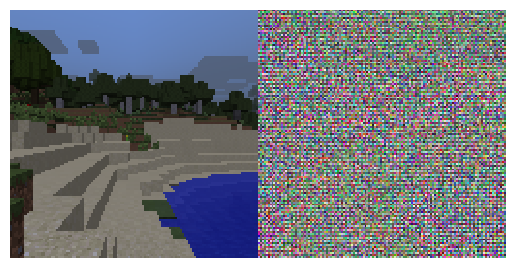

360: loss ae=484.0562438964844


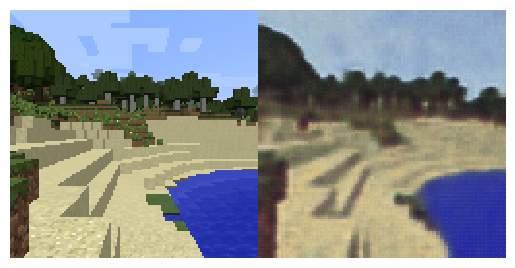

720: loss ae=4846.478515625


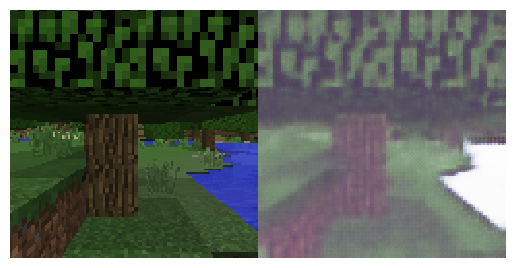

1080: loss ae=935.4096069335938


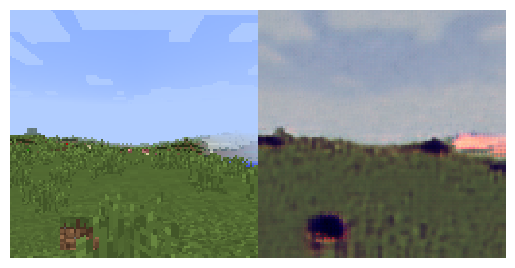

1440: loss ae=4679.53125


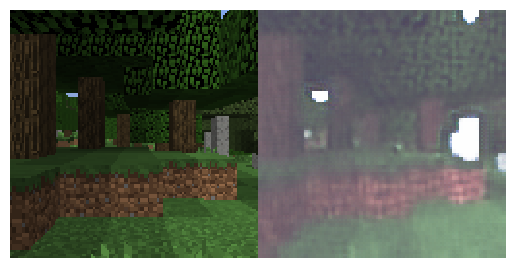

1800: loss ae=2053.490234375


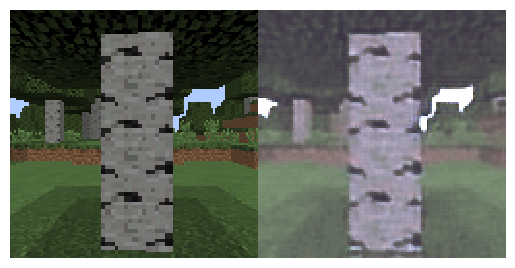

2160: loss ae=1296.374755859375


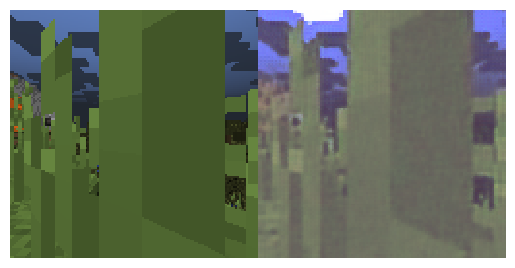

2520: loss ae=2177.60546875


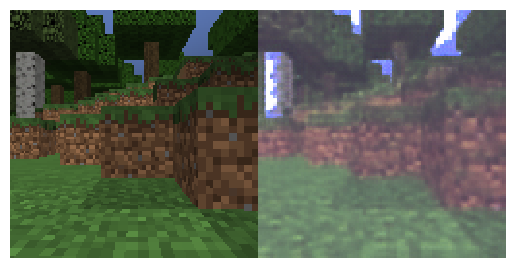

2880: loss ae=2958.641357421875


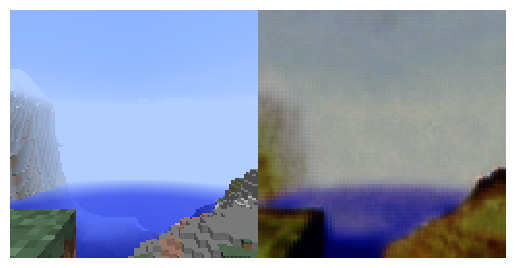

3240: loss ae=1823.087646484375


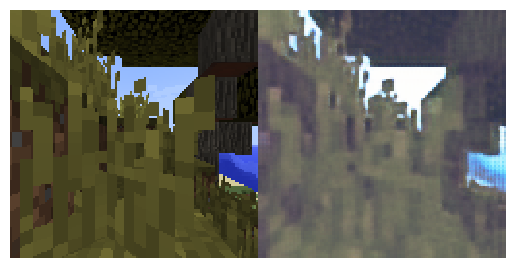

3600: loss ae=1189.903076171875


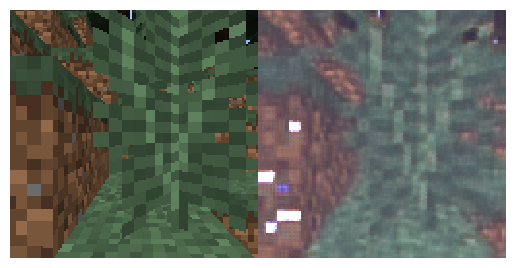

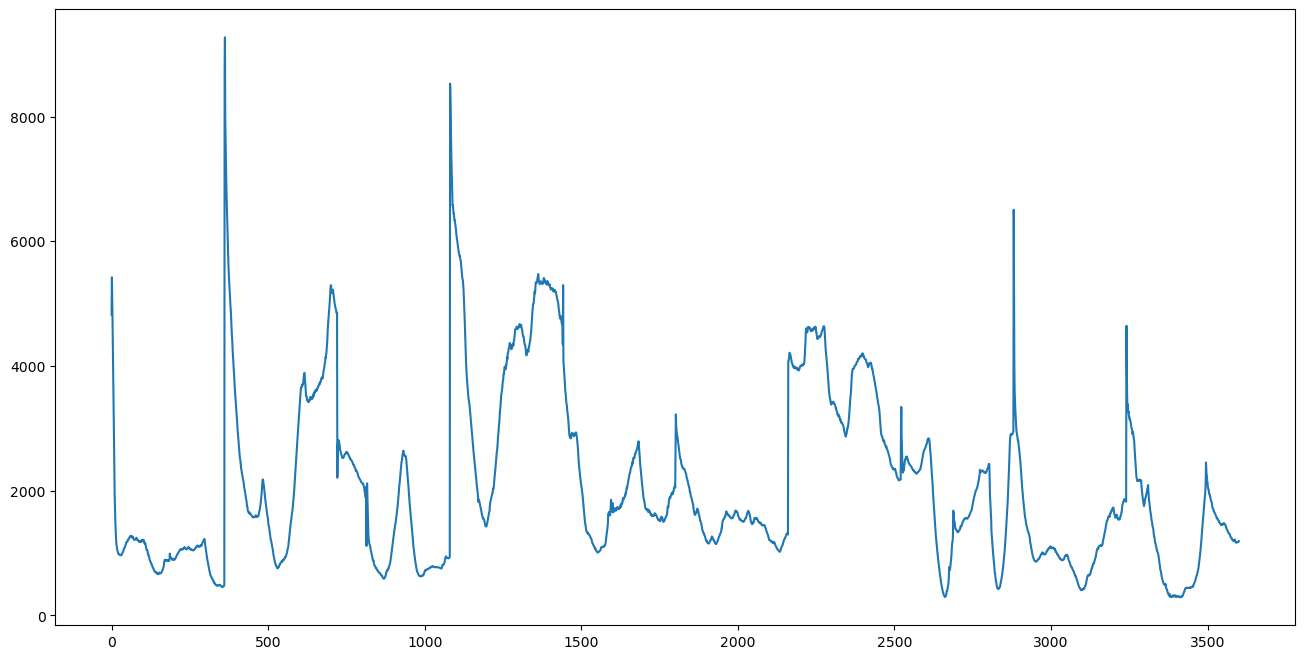

In [13]:
model_lr = 1e-4
center_lr = 1e-5
model_optim = opt_method(model.parameters(), lr=model_lr)
center_optim = opt_method(model.center.parameters(), lr=center_lr)
model.train()

if not MALMO_HOST.getWorldState().is_mission_running:
    start_mission()

session_id = f"{datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M-%S')}"
save_root = Path("./runs/"+session_id+"/")
save_root.mkdir()

losses = []
images = []

iters = 3601
show_step=360
reset_step=360
print_step=360
random_enc_step=100

for i in range(iters):
    MALMO_HOST.sendCommand(f"setYaw {i%360}")
    try:
        img, img_tens, agent_data = get_mc_img(False)
    except:
        start_mission()
        continue

    model_enc = model.encode(img_tens)
    channels = model_enc.shape[1]
    model_enc_noisy = model_enc + torch.randn((1,channels,64,64), requires_grad=True).to(DEVICE)
    model_center = model.center(model_enc_noisy.transpose(1,3)).transpose(1,3)    
    
    ##############
    # CLUSTERING #
    ##############
    model_enc_np = model_center.detach().squeeze().cpu().numpy()
    model_enc_np_flat = model_enc_np.reshape((channels, 64*64)).transpose((1,0))
    model_enc_flat = model_center.flatten(start_dim=2, end_dim=3)

    dbscanner = sklearn.cluster.DBSCAN(eps=1, min_samples=16)
    model_enc_clusters = dbscanner.fit_predict(model_enc_np_flat)
#     model_enc_clusters_unraveled = torch.Tensor(model_enc_clusters.reshape((1,1,64,64))).to(DEVICE)
#     model_enc_clusters_unraveled = torch.concat([model_enc_clusters_unraveled,model_enc_clusters_unraveled,model_enc_clusters_unraveled], dim=1)
#     model_enc_clusters_unraveled = tfunc.resize(model_enc_clusters_unraveled, (128, 128) ) + 1
#     model_enc_clusters_unraveled /= len(set(dbscanner.labels_))

    
    for cnum in set(dbscanner.labels_):
        if cnum == -1:
            continue
        cluster_points = model_enc_flat[:,:,model_enc_clusters==cnum]
        cluster_mean = cluster_points.mean(dim=2)
        cluster_std = cluster_points.std(dim=2)
        
    clustering_loss.backward(retain_graph=True)
    center_optim.step()
    center_optim.zero_grad()
    
    
    model_center = model.center(model_enc_noisy.transpose(1,3)).transpose(1,3)
    model_out = model.decode(model_center)
    loss = loss_fn(img_tens, model_out)
    loss.backward()
    model_optim.step()

    losses.append(loss.item())
    model_optim.zero_grad()

    if i % print_step == 0:
        print(f"{i}: loss ae={loss.item()}")
    if i % show_step == 0:
        image = torch.concat([img_tens, model_out], dim=3)
        draw_image(image, show=True)
        images.append(image.detach().cpu().squeeze())
    if reset_step is not None and i % reset_step == 0 and i > 0:
        MALMO_HOST.sendCommand("quit")
        time.sleep(1)
        start_mission()


with open(save_root.joinpath("losses.csv"), "w") as csv_file:
    for loss in losses:
        csv_file.write(f"{loss},\n")
for i, img in enumerate(images):
    draw_image(img, save_root.joinpath(f"images_{i*show_step}.png"))
plt.figure(figsize=(16, 8))
plt.plot(losses)
plt.savefig(save_root.joinpath("losses.png"))
with open(save_root.joinpath("model.txt"), "w") as model_file:
    model_file.write(str(model))
    model_file.write(str(model_optim))

MALMO_HOST.sendCommand("quit")

In [14]:
torch.save(model.state_dict(), str(save_root.joinpath("model.pth")))

In [15]:
# model.load_state_dict(torch.load("/home/boggsj/Coding/research/pytorch_cpp_test/runs/2022-12-24_11-55-40/model.pth"))

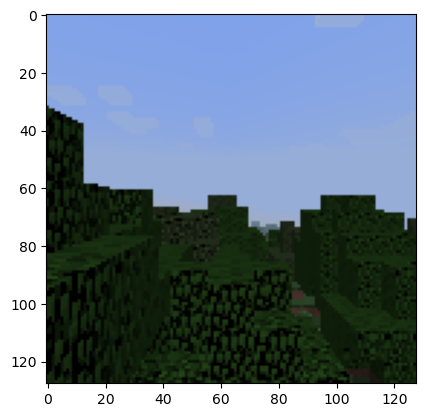

In [29]:
start_mission()
test_img, test_tens, ad = get_mc_img(True)#, transform=tfunc.autocontrast)

torch.Size([1, 256, 64, 64])


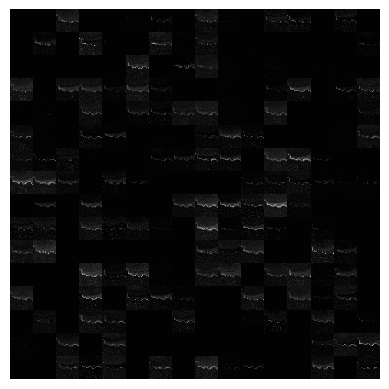

torch.Size([1, 3, 128, 128])


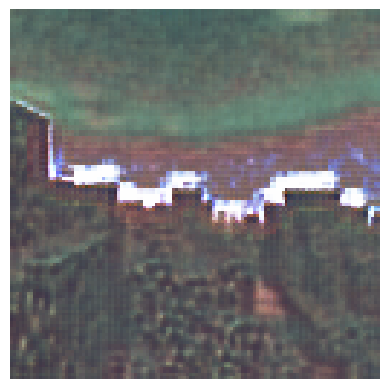

In [30]:
test_enc = model.encode(test_tens)
channels = test_enc.shape[1]
test_enc_noisy = test_enc + torch.randn((1,channels,64,64), requires_grad=True).to(DEVICE)
test_center = model.center(test_enc_noisy.transpose(1,3)).transpose(1,3)
test_dec = model.decode(test_center)
print(test_center.shape)
draw_layers(test_center, show=True)

print(test_dec.shape)
draw_image(test_dec, show=True)

In [31]:
embedder = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=64)

In [32]:
test_enc_np = test_enc.squeeze().detach().cpu().numpy()
test_enc_np_flat = test_enc_np.reshape((256, 64*64)).transpose((1,0))
print(test_enc_np[:,0,0] - test_enc_np_flat[0,:])
embedding = embedder.fit_transform(test_enc_np_flat)
print(embedding.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4096, 2)


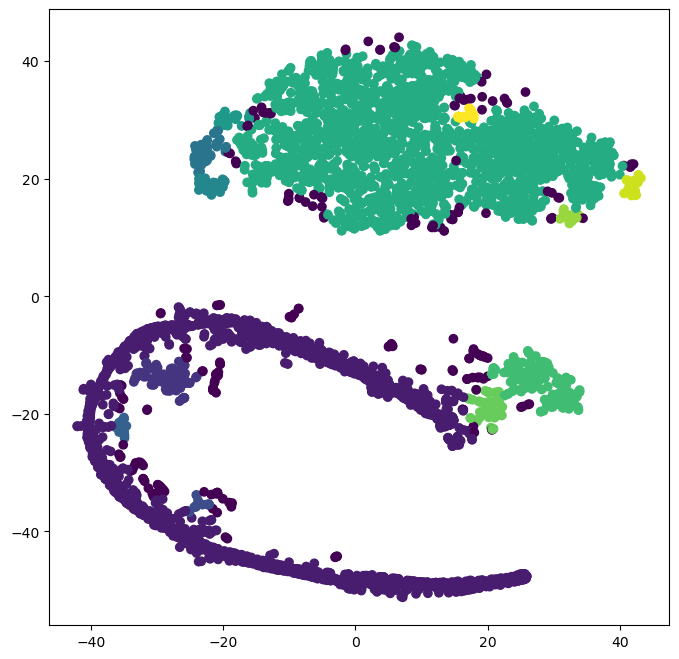

In [33]:
dbscanner = sklearn.cluster.DBSCAN(eps=2., min_samples=16)
clusters = dbscanner.fit_predict(embedding)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
# ax = fig.add_subplot(projection='3d')
# plt.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c=clusters)
plt.scatter(embedding[:,0], embedding[:,1], c=clusters)
plt.show()
plt.close()

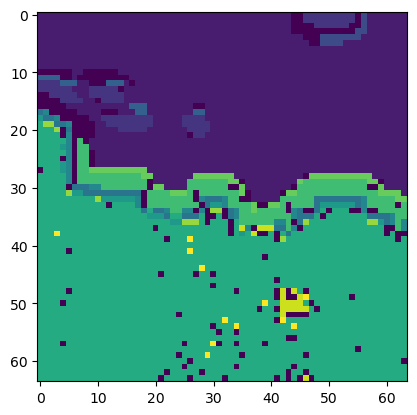

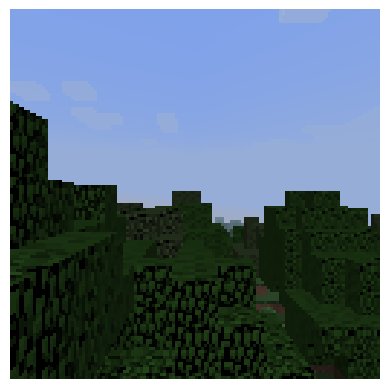

In [34]:
clusters_unraveled = clusters.reshape((64,64))
plt.imshow(clusters_unraveled)
plt.show()
plt.close()
draw_image(test_tens, show=True)

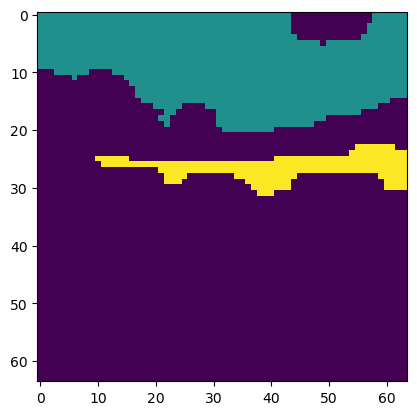

In [37]:
dbscanner = sklearn.cluster.DBSCAN(eps=1, min_samples=16)
clusters_enc = dbscanner.fit_predict(test_enc_np_flat)
clusters_enc_unraveled = clusters_enc.reshape((64,64))

plt.imshow(clusters_enc_unraveled)
plt.show()
plt.close()

In [ ]:
dim = 256
test_enc_clusters = torch.Tensor(clusters_enc).to(DEVICE)
test_enc_flat = test_enc.reshape((dim, 64*64))

cluster_means = {}
cluster_stds = {}
cluster_members = {}
for cnum in set(dbscanner.labels_):
    cluster_points = test_enc_flat[:,test_enc_clusters==0]
    cluster_means[cnum] = cluster_points.mean(dim=1).detach().cpu().numpy()
    cluster_stds[cnum] = cluster_points.std(dim=1).detach().cpu().numpy()
    cluster_members[cnum] = cluster_points.detach().cpu().numpy()
    
random_enc = np.zeros((dim, 64, 64))
for x in range(64):
    for y in range(64):
        cnum = clusters_enc_unraveled[x,y]
        random_enc[:,x,y] = cluster_members[cnum][:,randint(0, cluster_members[cnum].shape[1]-1)]
#         mean = cluster_means[clusters_enc_unraveled[x,y]]
#         std = cluster_stds[clusters_enc_unraveled[x,y]]
#         random_enc[:,x,y] = np.random.uniform(mean-(1*std), mean+(1*std))
#         random_enc[:,x,y] = np.random.normal(mean,std)

In [ ]:
random_enc_tens = torch.Tensor(random_enc).unsqueeze(0).to(DEVICE)

In [ ]:
rand_dec = model.decode(random_enc_tens)
print(rand_dec.shape)

draw_image(rand_dec, show=True)

In [ ]:
#     model_enc_noisy = model_enc + torch.randn((1,256,64,64), requires_grad=True).to(DEVICE)

    ##############
    # CLUSTERING #
    ##############
#     if i % random_enc_step == 0:
#         channels = model_enc.shape[1]
#         model_enc_np = model_enc.squeeze().detach().cpu().numpy()
#         model_enc_np_flat = model_enc_np.reshape((channels, 64*64)).transpose((1,0))
#         model_enc_flat = model_enc.flatten(start_dim=2, end_dim=3)

#         dbscanner = sklearn.cluster.DBSCAN(eps=0.5, min_samples=16)
#         model_enc_clusters = dbscanner.fit_predict(model_enc_np_flat)
#         model_enc_clusters_unraveled = model_enc_clusters.reshape((64,64))

#         cluster_means = {}
#         cluster_stds = {}
#         cluster_members = {}
#         for cnum in set(dbscanner.labels_):
#             cluster_points = model_enc_flat[:,:,model_enc_clusters==cnum]
#             cluster_means[cnum] = cluster_points.mean(dim=2).detach().cpu().numpy()
#             cluster_stds[cnum] = cluster_points.std(dim=2).detach().cpu().numpy()
#             cluster_members[cnum] = cluster_points.detach().cpu().numpy()

#         random_enc = np.zeros((channels, 64, 64))
#         for x in range(64):
#             for y in range(64):
#                 cnum = model_enc_clusters_unraveled[x,y]
#     #             random_enc[:,x,y] = cluster_members[cnum][:,randint(0, cluster_members[cnum].shape[1]-1)]
#                 mean = cluster_means[cnum]
#                 std = cluster_stds[cnum]
#     #             random_enc[:,x,y] = np.random.uniform(mean-(1*std), mean+(1*std))
#                 random_enc[:,x,y] = np.random.normal(mean,std)
#         model_enc = torch.Tensor(random_enc).unsqueeze(0).to(DEVICE)
            
    #######
    # END #
    #######
#         model.eval()
#         discriminator.eval()
        
#         for gen_i in range(generator_iters):
#             gen_input_batch = torch.randn(1, 2048, 1, 1).to(DEVICE)
#             gen_out = gen_model(gen_input_batch)
#             dec_gen_out = model.decode(gen_out)
#             disc_out = discriminator(dec_gen_out)

#             gen_loss = disc_loss_fn(disc_out, real)
#             gen_loss.backward()
            
#             gen_optim.step()
#             gen_optim.zero_grad()
            
#             if gen_i % generator_print_step == 0:
#                 print(f"GEN-{gen_i}: gen={gen_loss.item()}")
        
#         draw_image(dec_gen_out, show=True)

#         model.train()
#         discriminator.train()